![IITIS](pictures/logoIITISduze.png)

# Introduction to Quadratic Unconstrained Binary Optimisation
Quadratic Unconstrained Binary Optimization (QUBO) is a mathematical model used for solving combinatorial optimization problems. As name sugests it is concerned with models where there are quadratic dependencies between variables, there are no constrains and variables are binary. This description encompases suprisingly large class of problems, such as MAX-CUT, traveling salesman or job shob sheduling.  

## Definition
The QUBO model is expressed by the following optimization problem. Given symmetric matrix $Q$, find binary vector $\bm{x}^*$ such that:

$$ \bm{x}^* = \arg \min_x \bm{x}Q\bm{x}^T = \sum_i \sum_j Q_{i,j} x_i x_j$$

It is common to change the Q matrix into upper triangular form, which can be
achieved without loss of generality simply as follows. For all $i$ and $j$ with $j>i$ , replace $Q_{ij}$ by $Q_{ij} + Q_{ji}$ . Then replace all $Q_{ji}$
for $j < i$ by 0. 

It is worth noting that for binary variables, $x^2 = x$. This allows us to divide QUBO into linear part on the diagonal and quadratic part:

$$ \bm{x}Q\bm{x}^T =  \sum_i Q_{i,i} x_i + \sum_{i \neq j} Q_{i,j} x_i x_j$$




## Conection to Ising Model

The formula given above is suspiciously similar to definition of Ising model. As reminder, The definition of ising model is:

$$
    H(\textbf{s}) =  \sum_{i < j} J_{ij} s_i s_j + \sum_i h_i s_i
$$

where we assume that $\textbf{J}$ is a uper triangular matrix, $i=1, \ldots, N$ and  $s_i = \pm 1$. 


In fact solving QUBO and finding ground states of ising model are equivalent problems!. They can be relatively easy changed into each other by performing following substitution

$$x_i = \frac{s_i + 1}{2}$$
$$s_i = 2x_i - 1$$

If we substitute those variable to respective formulas we get:

$$
Q_{ij} = 4 J_{ij} 
$$
$$
Q_{ii} = 2h_i - 2\sum_{j \neq i} J_{i,j}
$$

and

$$
J_{ij} = \frac{1}{4} Q_{i,j}
$$
$$
h_{i} = \frac{1}{2}Q_{i,i} + \frac{1}{4} \sum_{j \neq i} Q_{i,j}
$$

It is important to remember that transforimation generates some additional constant, so obtained values of objective funtion cannot be directly compared. 

### The `pyqubo` and `dimod` packages

There are two really useful packages worth knowing. The `pyqubo` allows one to create QUBOs or Ising models from flexible mathematical expressions easily. The `dimod` is the standard package for storing and sampling quadratic models (this is wider class of models than QUBO). Both of them are compatible with the D-Waves Ocean software.

In [6]:
import pyqubo
# basic tutorial

In [ ]:
import dimod
# basic tutorial

## Solving Example QUBO

This first example will lay the ground work to see better different problems can be cast in QUBO form.
To begin, consider the optimization problem:
$$
\text{minimize} \, y = -5x_1 -3x_2 -8x_3 - 6x_4 + 4x_1x_2 + 8x_1x_3 + 2x_2x_3 + 10x_3x_4
$$

We will make several observations:
1. The function to be minimized has a linear part $-5x_1 -3x_2 -8x_3 - 6x_4$ and quadratic part $4x_1x_2 + 8x_1x_3 + 2x_2x_3 + 10x_3x_4$
2. Since for binary variables $x_i = x_i^2$, then we can write linear part as
$$
-5x_1^2 -3x_2^2 -8x_3^2 - 6x_4^2
$$
3. Then we can re-write the model in the following matrix form:
$$
\text{minimize} y = [x_1 \, x_2 \, x_3 \, x_4] \begin{bmatrix} 
-5 & 4 & 8 & 0 \\ 
0 & -3 & 2 & 0 \\
0 & 0 & -8 & 10 \\
0 & 0 & 0 & -6
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4
\end{bmatrix}
$$

4. Which can be writen as 
$$
y = \arg \min_x \bm{x}Q\bm{x}^T
$$
notice, that here we use convention of keeping $Q$ as an uper-triangular matrix.

5. Other than the binary restrictions on the decision variables, QUBO is an unconstrained model with all problem data being contained in the $Q$ matrix. This fact makes the QUBO model atractive framework for several optimisation problems.

In the code below we will find the solution.

In [20]:
from pyqubo import Binary

# Define problem
x1, x2, x3, x4 = Binary("x1"), Binary("x2"), Binary("x3"), Binary("x4")
y = -5*x1 -3*x2 - 8*x3 - 6*x4 + 4*x1*x2 + 8*x1*x3 + 2*x2*x3 + 10*x3*x4

# Compile problem to get model
model = y.compile()

# Call ‘to_qubo()’ to get QUBO coefficients.
qubo, offset = model.to_qubo()

# See that the model defaults to treating linear coeficients as "self-quadratic"
print("QUBO: ", qubo, "\n")



{('x2', 'x2'): -3.0, ('x3', 'x1'): 8.0, ('x3', 'x2'): 2.0, ('x2', 'x1'): 4.0, ('x1', 'x1'): -5.0, ('x3', 'x3'): -8.0, ('x3', 'x4'): 10.0, ('x4', 'x4'): -6.0}


In [36]:
#we will solve this qubo using simulated annealing. Altrought there are other solvers ready for the task.
from neal import SimulatedAnnealingSampler

sampler = SimulatedAnnealingSampler()

sampleset = sampler.sample_qubo(qubo, num_reads=10, seed=42)
# The `num_reads` parameter controls how many times we run this algorithm. As this is stochastic heuristic, the best practice is to run simulated annealing several times. 
print(sampleset)

  x1 x2 x3 x4 energy num_oc.
0  1  0  0  1  -11.0       1
2  1  0  0  1  -11.0       1
3  1  0  0  1  -11.0       1
4  1  0  0  1  -11.0       1
5  1  0  0  1  -11.0       1
7  1  0  0  1  -11.0       1
8  1  0  0  1  -11.0       1
9  1  0  0  1  -11.0       1
1  0  1  1  0   -9.0       1
6  0  1  1  0   -9.0       1
['BINARY', 10 rows, 10 samples, 4 variables]


# Encoding problems as QUBO

Is this section we will present some problems witch have natural formulation as QUBO.

##  The Number Partitioning Problem

## Max-Cut

The Max Cut problem is one of the most famous problems in combinatorial optimization. Given
an undirected graph $G(V, E)$ with a vertex set $V$ and an edge set $E$, the Max Cut problem seeks to
partition $V$ into two sets such that the number of edges between the two sets (considered to be
severed by the cut), is a large as possible.
We can model this problem by introducing binary variables satisfying $𝑥_i = 1$ if vertex i is in one
set and $𝑥_i = 0$ if it is in the other set. Viewing a cut as severing edges joining two sets, to leave
endpoints of the edges in different vertex sets, the quantity $𝑥_i  + 𝑥_j − 2𝑥_i 𝑥_j$ identifies whether
the edge $(𝑖, 𝑗)$ is in the cut.

Thus, the problem of maximizing the number of edges in the cut can be formulated as:
$$\max \sum_{(i,j) \in G} (𝑥_i  + 𝑥_j − 2𝑥_i 𝑥_j) = \min \sum_{(i,j) \in G} (-𝑥_i  - 𝑥_j + 2𝑥_i 𝑥_j) $$


![example](pictures/cut_examples.png)

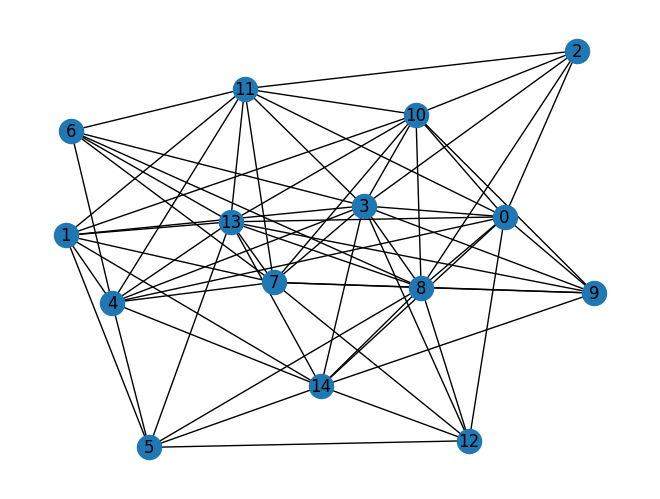

In [5]:
import networkx as nx

# Create problem graph
graph = nx.erdos_renyi_graph(n=15, p=0.6, seed=42)
nx.draw(graph, with_labels=True)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 energy num_oc.
0  1  0  0  1  0  1  1  1  0  0  1  0  0  0  1  -42.0       1
1  0  1  1  0  1  0  0  0  1  1  0  1  1  1  0  -42.0       1
2  1  0  0  1  0  1  1  1  0  0  1  0  0  0  1  -42.0       1
3  0  1  1  0  1  0  0  0  1  1  0  1  1  1  0  -42.0       1
4  0  1  1  0  1  0  0  0  1  1  0  1  1  1  0  -42.0       1
5  0  1  1  0  1  0  0  0  1  1  0  1  1  1  0  -42.0       1
6  0  1  1  0  1  0  0  0  1  1  0  1  1  1  0  -42.0       1
7  0  1  1  0  1  0  0  0  1  1  0  1  1  1  0  -42.0       1
8  1  0  0  1  0  1  1  1  0  0  1  0  0  0  1  -42.0       1
9  0  1  1  0  1  0  0  0  1  1  0  1  1  1  0  -42.0       1
['BINARY', 10 rows, 10 samples, 15 variables]


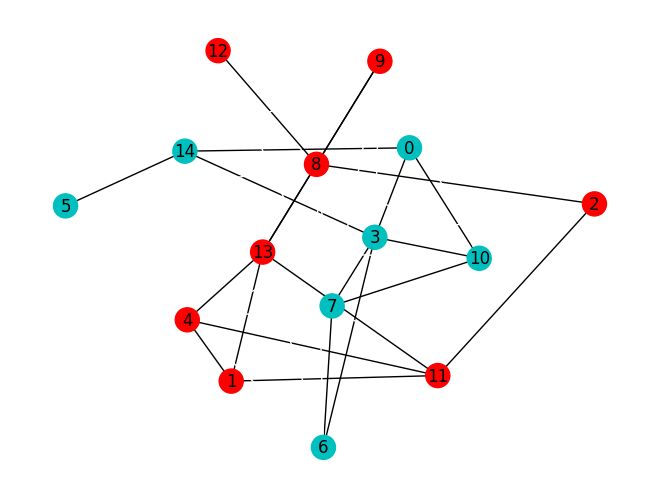

In [18]:
# We will build QUBO using BinaryQuadraticModel from dimod and solve it using simulated annealing. We will implement this algorithm in the later part of the course

from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler

from collections import defaultdict

Q = defaultdict(int)
for i, j in graph.edges:
    Q[(i,i)] += -1
    Q[(j,j)] += -1
    Q[(i,j)] += 2

bqm = BinaryQuadraticModel(vartype="BINARY")
bqm = bqm.from_qubo(Q)

sa = SimulatedAnnealingSampler()

solution = sa.sample(bqm, num_reads=10, num_sweeps=10000, num_sweeps_per_beta=10)
print(solution)
best = solution.first.sample
# Interpret best result in terms of nodes and edges
S0 = [node for node in graph.nodes if not best[node]]
S1 = [node for node in graph.nodes if best[node]]
cut_edges = [(u, v) for u, v in graph.edges if best[u]!=best[v]]
uncut_edges = [(u, v) for u, v in graph.edges if best[u]==best[v]]

# Display best result
nx.draw(graph, node_color=["r" if i in S0 else "c" for i in list(graph.nodes)], with_labels=True, 
       edge_color=["black" if e in uncut_edges else "white" for e in list(graph.edges)])


# Futher Reading
